In [160]:
#https://pypi.org/project/oidv6/
pip install oidv6

Note: you may need to restart the kernel to use updated packages.


In [6]:
!oidv6 downloader --dataset OIDv6/ --type_data all --classes Ambulance Bus Car Truck Van --limit 1000 --yes 

--------------------------------------------------------------------------------
OIDv6 - Downloading single or multiple classes from the Open Images V6 Dataset ...
--------------------------------------------------------------------------------
[2021-05-27 18:54:30] Start: 
	Author: Dmitry Ryumin
	Email: dl_03.03.1991@mail.ru
	Maintainer: Dmitry Ryumin
	Version: 1.0.5
--------------------------------------------------------------------------------
[2021-05-27 18:54:30] Checking command line arguments for validity ...
[2021-05-27 18:54:30] Creating Directories for Metadata ...
--------------------------------------------------------------------------------
[2021-05-27 18:54:30] Downloading "ambulance" ...
    Extracting data from "oidv6-train-annotations-bbox.csv" ...
^C
Traceback (most recent call last):
  File "/opt/conda/bin/oidv6", line 8, in <module>
    sys.exit(main())
  File "/opt/conda/lib/python3.7/site-packages/oidv6/samples/run.py", line 159, in main
    run.run()
  File "/o

In [16]:
import os
import shutil

lists = ['ambulance','bus','car','truck','van']
for li in lists:
    path = "OIDv6/multidata/validation/labels"
    new_path = "OIDv6/validation/"+li+"/labels"
    files = os.listdir(path)
    for file in files:
        if li in file:
            if not os.path.isdir(new_path):
                os.makedirs(new_path)
            shutil.move(os.path.join(path, file), new_path)
print("done")

done


In [1]:
import os
from pprint import pprint
from six import BytesIO
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2 as cv
from PIL import Image, ImageColor, ImageDraw, ImageFont, ImageOps

from tensorflow.keras.models import load_model
from tensorflow.keras.applications.densenet import preprocess_input
from tensorflow.keras import models
from sklearn.utils import class_weight
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm

In [25]:
# Training Dataset Normalize and Augmentation
train_datagen=ImageDataGenerator(
    rescale=(1/255.),
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    shear_range=0.2,
    rotation_range=20,
    brightness_range=[0.8,1.2],
    horizontal_flip=True,
    #fill_mode="nearest"
    )

test_datagen=ImageDataGenerator(
    rescale=(1/255.)
    )

validation_datagen=ImageDataGenerator(
    rescale=(1/255.)
    )

traindir = "OIDv6/train" 
testdir = "OIDv6/test"
valtdir = "OIDv6/validation"

train_generator=train_datagen.flow_from_directory(
    traindir,
    target_size =(224, 224),
    class_mode='categorical',
    batch_size=32
    )

test_generator=test_datagen.flow_from_directory(
    testdir,
    target_size =(224, 224),
    class_mode='categorical',
    batch_size=32
    )

validation_generator=test_datagen.flow_from_directory(
    valtdir,
    target_size =(224, 224),
    class_mode='categorical',
    batch_size=32
    )

class_weights = class_weight.compute_class_weight(
    'balanced',
    np.unique(train_generator.classes),
    train_generator.classes
    )

print(train_generator.labels)
print(train_generator.class_indices)
print(class_weights)

Found 3338 images belonging to 5 classes.
Found 2243 images belonging to 5 classes.
Found 1399 images belonging to 5 classes.
[1 1 1 ... 4 4 4]
{'.ipynb_checkpoints': 0, 'ambulance': 1, 'bus': 2, 'car': 3, 'truck': 4}
[2.46893491 0.8345     0.8345     0.8345    ]


/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass classes=[1 2 3 4], y=[1 1 1 ... 4 4 4] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


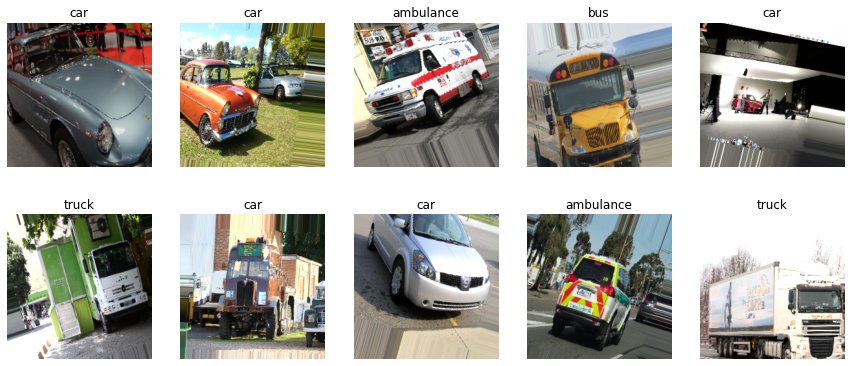

In [129]:
target_labels = next(os.walk(traindir))[1]

target_labels.sort()

batch = next(train_generator)
batch_images = np.array(batch[0])
batch_labels = np.array(batch[1])

target_labels = np.asarray(target_labels)

plt.figure(figsize=(15,10))
for n, i in enumerate(np.arange(10)):
    ax = plt.subplot(3,5,n+1)
    plt.imshow(batch_images[i])
    plt.title(target_labels[np.where(batch_labels[i]==1)[0][0]])
    plt.axis('off')

In [119]:
IMG_SIZE = (224,224)
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [29]:
base_model.summary()
len(base_model.layers)

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
_______________________________________________________________________________

154

In [30]:
image_batch, label_batch = next(iter(train_generator))

feature_batch = base_model(image_batch)

#Freeze the convolutional layers
base_model.trainable = False

# global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
# feature_batch_average = global_average_layer(feature_batch)

# prediction_layer = tf.keras.layers.Dense(5)
# prediction_batch = prediction_layer(feature_batch_average)

#Model Building
model = tf.keras.Sequential([
  base_model,
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(256, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(5, activation='softmax')
])
# inputs = tf.keras.Input(shape=( 224, 224, 3))
# x = base_model(inputs, training=False)
# x = global_average_layer(x)
# x = tf.keras.layers.Dropout(0.2)(x)
# x = tf.keras.layers.Dense(512, activation='relu')(x)
# outputs = prediction_layer(x)
# model = tf.keras.Model(inputs, outputs)


# print(feature_batch.shape)
# print(feature_batch_average.shape)
# print(prediction_batch.shape)

In [31]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [32]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 1280)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               327936    
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 1285      
Total params: 2,587,205
Trainable params: 329,221
Non-trainable params: 2,257,984
______________________________________

In [33]:
initial_epochs = 5

In [34]:
history = model.fit(train_generator,
                    epochs=initial_epochs,
                    validation_data=validation_generator)

Epoch 1/5
105/105 [==============================] - 247s 2s/step - loss: 1.5021 - accuracy: 0.3531 - val_loss: 0.6067 - val_accuracy: 0.8070
Epoch 2/5
105/105 [==============================] - 242s 2s/step - loss: 0.8688 - accuracy: 0.6671 - val_loss: 0.5626 - val_accuracy: 0.8063
Epoch 3/5
105/105 [==============================] - 240s 2s/step - loss: 0.8078 - accuracy: 0.6889 - val_loss: 0.4774 - val_accuracy: 0.8320
Epoch 4/5
105/105 [==============================] - 241s 2s/step - loss: 0.7713 - accuracy: 0.6911 - val_loss: 0.4868 - val_accuracy: 0.8234
Epoch 5/5
105/105 [==============================] - 243s 2s/step - loss: 0.7265 - accuracy: 0.7187 - val_loss: 0.4787 - val_accuracy: 0.8292


In [35]:
#Un-Freeze Top Layer
base_model.trainable = True

# Total Layer on Based Model
print("Total Layer on Based Model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 123 #freeze first 80%

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Total Layer on Based Model:  154


In [36]:
# creating scheduled learning rate decay
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    base_learning_rate,
    decay_steps=50,
    decay_rate=0.9)

In [37]:
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule),
              metrics=['accuracy'])

In [38]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 1280)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               327936    
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 1285      
Total params: 2,587,205
Trainable params: 1,947,781
Non-trainable params: 639,424
______________________________________

In [39]:
checkpoint_path = "new_checkpoint/cp_rev_1.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

In [40]:
fine_tune_epochs = 25
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_generator,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_generator,
                         callbacks=[cp_callback])

Epoch 5/30
105/105 [==============================] - 277s 3s/step - loss: 0.8110 - accuracy: 0.6882 - val_loss: 0.7771 - val_accuracy: 0.7269

Epoch 00005: saving model to new_checkpoint/cp_rev_1.ckpt
Epoch 6/30
105/105 [==============================] - 267s 3s/step - loss: 0.6348 - accuracy: 0.7561 - val_loss: 0.6849 - val_accuracy: 0.7527

Epoch 00006: saving model to new_checkpoint/cp_rev_1.ckpt
Epoch 7/30
105/105 [==============================] - 268s 3s/step - loss: 0.5777 - accuracy: 0.7833 - val_loss: 0.6009 - val_accuracy: 0.7756

Epoch 00007: saving model to new_checkpoint/cp_rev_1.ckpt
Epoch 8/30
105/105 [==============================] - 266s 3s/step - loss: 0.5130 - accuracy: 0.8005 - val_loss: 0.5936 - val_accuracy: 0.7898

Epoch 00008: saving model to new_checkpoint/cp_rev_1.ckpt
Epoch 9/30
105/105 [==============================] - 268s 3s/step - loss: 0.4560 - accuracy: 0.8345 - val_loss: 0.5607 - val_accuracy: 0.8020

Epoch 00009: saving model to new_checkpoint/cp_r

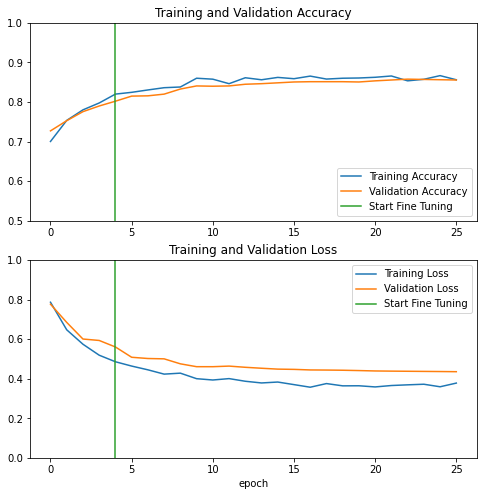

In [41]:
acc = history_fine.history['accuracy']
val_acc = history_fine.history['val_accuracy']

loss = history_fine.history['loss']
val_loss = history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.5, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [45]:
loss, accuracy = model.evaluate(test_generator)
print('Test accuracy :', accuracy)

71/71 [==============================] - 129s 2s/step - loss: 0.5047 - accuracy: 0.8235
Test accuracy : 0.8234507441520691


In [46]:
loss, accuracy = model.evaluate(validation_generator)
print('Validation accuracy :', accuracy)

44/44 [==============================] - 57s 1s/step - loss: 0.4356 - accuracy: 0.8556
Validation accuracy : 0.8556111454963684


In [42]:
model.save_weights('Checkpoint_ver2/Ambulance_checkpoint_ver2')

In [43]:
model.save('Model/TheATeam_model_ver2')

INFO:tensorflow:Assets written to: Model/TheATeam_model_ver2/assets


INFO:tensorflow:Assets written to: Model/TheATeam_model_ver2/assets


In [50]:
import shutil
shutil.make_archive('TheATeam_model_ver2', 'gztar', 'Model/TheATeam_model_ver2')

'/home/jupyter/TheATeam_model_ver2.tar.gz'

In [51]:
shutil.make_archive('Checkpoint_ver2', 'gztar', 'Checkpoint_ver2')

'/home/jupyter/Checkpoint_ver2.tar.gz'

In [53]:
model.save('TheATeam_model_ver2_h5',save_format='h5')

In [101]:
model.save('TheATeam_model_ver2_pb')

INFO:tensorflow:Assets written to: TheATeam_model_ver2_pb/assets


INFO:tensorflow:Assets written to: TheATeam_model_ver2_pb/assets


In [96]:
# Prediction Testing for a Single Image
from PIL import Image
import numpy as np
from skimage import transform
def load(filename):
   np_image = Image.open(filename)
   np_image = np.array(np_image).astype('float32')/255
   np_image = transform.resize(np_image, (224, 224, 3))
   np_image = np.expand_dims(np_image, axis=0)
   return np_image

image = load('Sample/ambulanceInTraffic_sample.jpg')
result = model.predict(image)
print("Ambulance Detected: {}".format(result[0][1]) if result[0][1]>0.3 else "Ambulance not detected: {}".format(result[0][1]))

Ambulance Detected: 0.9962981343269348


In [107]:
!pip show tensorflow

Name: tensorflow
Version: 2.4.1
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /opt/conda/lib/python3.7/site-packages
Requires: opt-einsum, wheel, typing-extensions, grpcio, wrapt, astunparse, h5py, keras-preprocessing, termcolor, absl-py, six, gast, numpy, flatbuffers, tensorboard, tensorflow-estimator, google-pasta, protobuf
Required-by: witwidget, tfx, tfx-bsl, tensorflow-transform, tensorflow-serving-api, tensorflow-model-analysis, tensorflow-io, tensorflow-data-validation, tensorflow-cloud, Keras, fairness-indicators, explainable-ai-sdk
